# 차원축소모듈
- input (reduction_pca,reduction_tsne,reduction_tsvd,reduction_auto)
    - input_df : 입력데이터, pd.DataFrame
    - n_comp : 차원축소 후 사용할 component 개수,int, default = 2
    - random_state : int, default =123
- input (reduction_auto)
    - learning_rate :int, default = 0.001
    - n_epoch : int. default = 100
    - cnt : mse print 간격, int,default = 10 
- output
    - pd.DataFrame

# 1. PCA

In [74]:
def reduction_pca(input_df,n_comp=2,random_state=123):
    from sklearn.decomposition import PCA
    return pd.DataFrame(PCA(n_components=n_comp, random_state=random_state).fit_transform(input_df.values))

# 2. T-SNE

In [75]:
def reduction_tsne(input_df,n_comp=2,random_state=123):
    from sklearn.manifold import TSNE
    return pd.DataFrame(TSNE(n_components=n_comp, random_state=random_state).fit_transform(input_df.values))

# 3. TSVD

In [76]:
def reduction_tsvd(input_df,n_comp=2,random_state=123):
    from sklearn.decomposition import TruncatedSVD
    return pd.DataFrame(TruncatedSVD(n_components=n_comp, random_state=random_state).fit_transform(input_df.values))

# 4. Auto Encoder

In [77]:
 def reduction_auto(input_df,n_comp=2,random_state=123,learning_rate=0.001,n_epoch=100,cnt = 10):
    import tensorflow as tf
    from tensorflow.contrib.layers import fully_connected
    n_input = input_df.shape[1]
    n_hidden = n_comp
    n_output = n_input

    #set encoder
    x_ph = tf.placeholder(tf.float32,shape = [None,n_input])
    hidden_layer = fully_connected(x_ph,n_hidden,activation_fn=None)
    y_model = fully_connected(hidden_layer,n_output,activation_fn=None)

    #set loss function, optimizer
    loss = tf.reduce_mean(tf.square(x_ph-y_model)) # MSE
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) # Adam
    train = optimizer.minimize(loss)

    #Initiate variables
    init = tf.global_variables_initializer()

    #run session
    with tf.Session() as sess:
        sess.run(init)
        for i in range(n_epoch):
            my_feed = {x_ph:input_df.values}
            sess.run(train, feed_dict = my_feed)
            if i % cnt == 0: 
                mse = sess.run(loss, feed_dict = my_feed)
                print(i, "\tMSE loss:", mse)
        result = sess.run(hidden_layer, feed_dict = my_feed)
    return pd.DataFrame(result)

# Test

In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import seaborn as sb
import matplotlib.pyplot as plt

In [79]:
# 시간이 오래걸려서 50:50 undersampling Data 로 test 했음

df = pd.read_csv(r'creditcard.csv')

# Scaling을 안했을 때 차원축소 효과가 좋지 않았음
df.Amount = RobustScaler().fit_transform(df.Amount.values.reshape(-1,1))
df.Time = RobustScaler().fit_transform(df.Time.values.reshape(-1,1))

fraud = df.loc[df.Class == 1]
df_suff = df.sample(frac = 1)
not_fraud = df_suff.loc[df.Class == 0][:492]

df_test = pd.concat([fraud,not_fraud])
x,y = df_test.drop(columns='Class'),df_test.Class

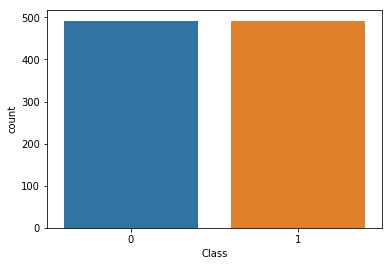

In [80]:
sb.countplot(y);

In [81]:
x_pca = reduction_pca(x,n_comp=2,random_state=123)
x_tsne = reduction_tsne(x,n_comp=2,random_state=123)
x_tsvd = reduction_tsvd(x,n_comp=2,random_state=123)
x_auto = reduction_auto(x,n_comp=2,random_state=123,learning_rate=0.001,n_epoch=100, cnt = 10)

0 	MSE loss: 16.70191
10 	MSE loss: 15.766327
20 	MSE loss: 15.126883
30 	MSE loss: 14.715056
40 	MSE loss: 14.44056
50 	MSE loss: 14.228196
60 	MSE loss: 14.031108
70 	MSE loss: 13.824063
80 	MSE loss: 13.594181
90 	MSE loss: 13.334495


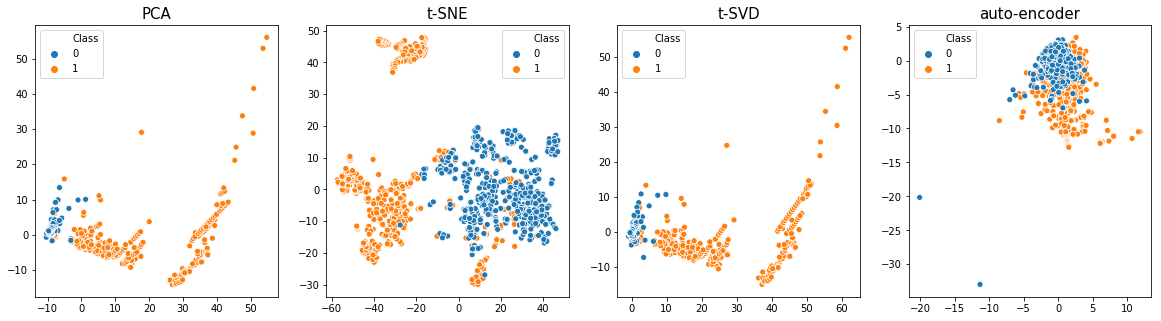

In [83]:
#시각화
fig,ax = plt.subplots(1,4,figsize = (20,5))
sb.scatterplot(x_pca[0].values,x_pca[1].values,hue = y, ax=ax[0])
ax[0].set_title('PCA',fontsize = 15)
sb.scatterplot(x_tsne[0].values,x_tsne[1].values,hue = y, ax=ax[1])
ax[1].set_title('t-SNE',fontsize = 15)
sb.scatterplot(x_tsvd[0].values,x_tsvd[1].values,hue = y, ax=ax[2])
ax[2].set_title('t-SVD',fontsize = 15)
sb.scatterplot(x_auto[0].values,x_auto[1].values,hue = y, ax=ax[3])
ax[3].set_title('auto-encoder',fontsize = 15)
plt.show()